### Parsing geojson

Geojson stores geometry as a list of latitude and longitude coordinates. It is necessary to choose a coordinate transformation suitable for further work with the graph. As far as tiles describe rather small area we are able to use [equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection).

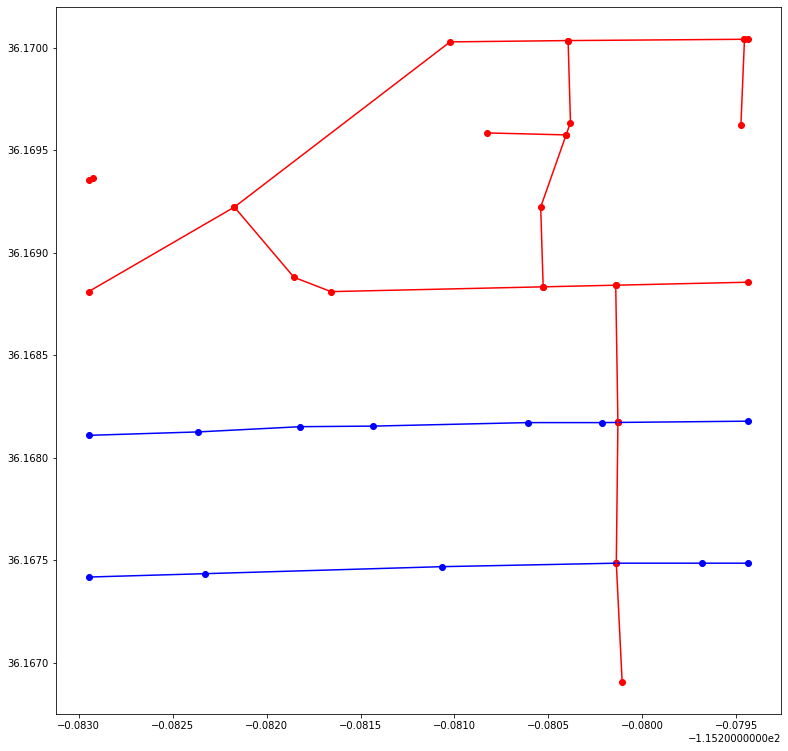

In [1]:
import json
import pylab as plt
import numpy as np

obj = json.load(open('media/input.geojson', 'r'))

fig, ax = plt.subplots(figsize=(13, 13))
features = obj["features"]
for feature in features:
    geometry = feature['geometry']
    if geometry['type'] == 'LineString':
        array = np.array(geometry['coordinates']).T
        ax.plot(array[0], array[1], color='r')
        ax.scatter(array[0], array[1], color='r')
    if geometry['type'] == 'MultiLineString':
        for line in geometry['coordinates']:
            array = np.array(line).T
            ax.plot(array[0], array[1], color='b')
            ax.scatter(array[0], array[1], color='b')

In [2]:
from osgeo import gdal


src = gdal.Open('media/input.tif')
ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
lrx = ulx + (src.RasterXSize * xres)
lry = uly + (src.RasterYSize * yres)

print("Degrees")
print(f"{ulx:.6f}, {uly:.6f}, {lrx:.6f}, {lry:.6f}")


def to_radian(degrees):
    return np.pi * degrees / 180

ulx, uly = to_radian(ulx), to_radian(uly)
lrx, lry = to_radian(lrx), to_radian(lry)

print("Radians")
print(f"{ulx:.6f}, {uly:.6f}, {lrx:.6f}, {lry:.6f}")


def equirectangular_projection(lon, lat):
    x = lon * np.cos(uly)
    y = lat
    return x, y

tl_x, tl_y = equirectangular_projection(ulx, uly)
br_x, br_y = equirectangular_projection(lrx, lry)
print("Projection")
print(f"{tl_x:.6f}, {tl_y:.6f}, {br_x:.6f}, {br_y:.6f}")

x0, y0 = tl_x, tl_y
x1, y1 = br_x, br_y
def transform(x, y):
    x = (x - x0) * src.RasterXSize / (x1 - x0)
    y = (y - y0) * src.RasterYSize / (y1 - y0)
    return x, y

tl_x, tl_y = transform(tl_x, tl_y)
br_x, br_y = transform(br_x, br_y)
print("Transform")
print(f"{tl_x:.6f}, {tl_y:.6f}, {br_x:.6f}, {br_y:.6f}")


def transform_coords(x, y):
    x, y = to_radian(x), to_radian(y)
    x, y = equirectangular_projection(x, y)
    return transform(x, y)

Degrees
-115.282948, 36.170418, -115.279438, 36.166908
Radians
-2.012067, 0.631293, -2.012006, 0.631232
Projection
-1.624272, 0.631293, -1.624222, 0.631232
Transform
0.000000, -0.000000, 1300.000000, 1300.000000


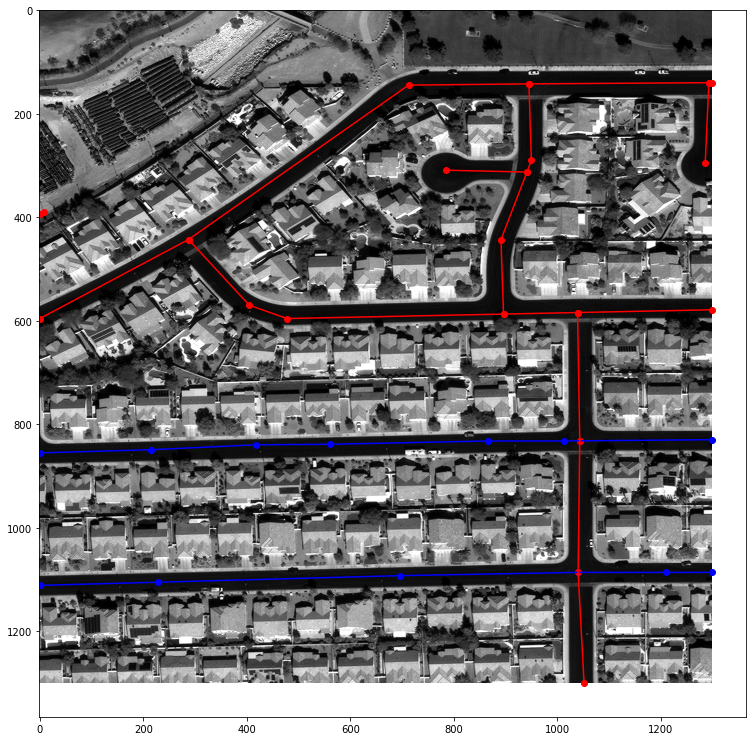

In [3]:
import cv2

img = cv2.imread('media/output.tif')
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(img)

features = obj["features"]
for feature in features:
    geometry = feature['geometry']
    if geometry['type'] == 'LineString':
        array = np.array(geometry['coordinates']).T
        x, y = transform_coords(array[0], array[1])
        ax.plot(x, y, color='r')
        ax.scatter(x, y, color='r')
    if geometry['type'] == 'MultiLineString':
        for line in geometry['coordinates']:
            array = np.array(line).T
            x, y = transform_coords(array[0], array[1])
            ax.plot(x, y, color='b')
            ax.scatter(x, y, color='b')